Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

# IMPORTANT: Make sure that the helper scripts are reachable (i.e., upload them to Colab!!)

In [ ]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

ModuleNotFoundError: ignored

# AlexNet CIFAR-10 Classifier

### Network Architecture

References
    
- [1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "[Imagenet classification with deep convolutional neural networks.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)" In Advances in Neural Information Processing Systems, pp. 1097-1105. 2012.


## Imports

In [ ]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

#### Setting a random seed

I recommend using a function like the following one prior to using dataset loaders and initializing a model if you want to ensure the data is shuffled in the same manner if you rerun this notebook and the model gets the same initial random weights:

In [ ]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#### Setting cuDNN and PyTorch algorithmic behavior to deterministic

Similar to the `set_all_seeds` function above, I recommend setting the behavior of PyTorch and cuDNN to deterministic (this is particulary relevant when using GPUs). We can also define a function for that:

In [ ]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

In [ ]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)

# Deterministic behavior not yet supported by AdaptiveAvgPool2d
#set_deterministic()

#### Import utility functions

In [ ]:
import sys

sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.

from helper_evaluate import compute_accuracy
from helper_data import get_dataloaders_cifar10
from helper_train import train_classifier_simple_v1

## Dataset

In [ ]:
### Set random seed ###
set_all_seeds(RANDOM_SEED)

##########################
### Dataset
##########################

train_transforms = transforms.Compose([transforms.Resize((40, 40)),
                                       transforms.RandomCrop((33, 33)),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((40, 40)),
                                      transforms.CenterCrop((33, 33)),
                                      transforms.ToTensor()])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 33, 33])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 33, 33])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 33, 33])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


## Model

In [ ]:
##########################
### MODEL
##########################

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 1 * 1, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 1 * 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

    def output(self, x):
        out = self.features(x)
        # out = self.avgpool(out)
        out = out.view(out.size(0), 256 * 1 * 1)
        out = self.classifier(out)
        return out

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [ ]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=DEVICE, 
                                      train_loader=train_loader, valid_loader=valid_loader, 
                                      logging_interval=25)

Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3041
Epoch: 001/040 | Batch 0025/0175 | Loss: 2.3019
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.3020
Epoch: 001/040 | Batch 0075/0175 | Loss: 2.2831
Epoch: 001/040 | Batch 0100/0175 | Loss: 2.1989
Epoch: 001/040 | Batch 0125/0175 | Loss: 2.1411
Epoch: 001/040 | Batch 0150/0175 | Loss: 2.1854
***Epoch: 001/040 | Train. Acc.: 18.594% | Loss: 2.036
***Epoch: 001/040 | Valid. Acc.: 19.580% | Loss: 2.021
Time elapsed: 1.57 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 2.0668
Epoch: 002/040 | Batch 0025/0175 | Loss: 2.0161
Epoch: 002/040 | Batch 0050/0175 | Loss: 2.0378
Epoch: 002/040 | Batch 0075/0175 | Loss: 2.0670
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.9796
Epoch: 002/040 | Batch 0125/0175 | Loss: 2.0413
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.9982
***Epoch: 002/040 | Train. Acc.: 20.391% | Loss: 1.958
***Epoch: 002/040 | Valid. Acc.: 21.700% | Loss: 1.934
Time elapsed: 3.04 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.9851
Epoch: 003/040

## Evaluation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


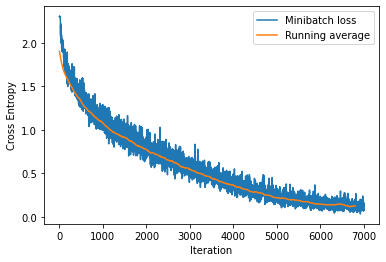

In [ ]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

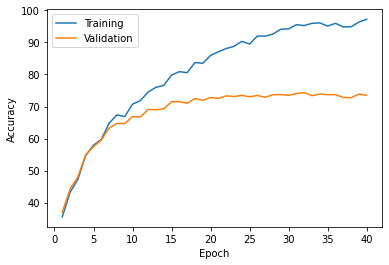

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 73.52%
Validation ACC: 73.52%
Test ACC: 72.71%


In [ ]:
# Write results to a file so that we can test the C++ accuracy thing
with open("./preds_AlexNet.txt", "w") as p:
    with open("./ground_AlexNet.txt", "w") as h:
        first = True
        for images, labels in test_loader:
            # Run the network inference to get the predicted values
            pred = sum(model(images.cuda()).cpu().tolist(), [])

            # Generate the ground truths
            ground = sum([ [ 1 if i == l else 0 for i in range(10) ] for l in labels ], [])

            # Append to the files
            if first:
                first = False
            else:
                p.write(" ")
                h.write(" ")
            p.write(' '.join([ str(s) for s in pred]))
            h.write(' '.join([ str(s) for s in ground]))

In [ ]:
# Extract the weights and junk
params = [(name, p.data.cpu().numpy()) for (name, p) in model.named_parameters()]

In [ ]:
# Find a single input batch
for images, _ in train_loader:
    break

# Assert the target directory exists
path = "./preload/AlexNet_CIFAR10"
if not os.path.exists(path):
    os.makedirs(path)

# Write the used inputs and outputs
np.savetxt(fname=f"{path}/input_0", delimiter=" ", X=images.cuda().view(-1, 3 * 33 * 33).tolist())
np.savetxt(fname=f"{path}/outputlayer8_0", delimiter=" ", X=model.output(images.cuda().view(-1, 3, 33, 33)).data.cpu().view(-1))

# Write the layers we want
for (i, resize_to) in enumerate([ (11*11*3, 96), (5*5*96, 256), (3*3*256, 384), (3*3*384, 384), (3*3*384, 256), None, None, None ]):
    # Write the layer's weights
    if resize_to is not None:
        np.savetxt(fname=f"{path}/weight{i + 1}_0", delimiter=" ", X=params[2 * i][1].reshape(resize_to).tolist())
    else:
        np.savetxt(fname=f"{path}/weight{i + 1}_0", delimiter=" ", X=params[2 * i][1].tolist())

    # Write the biases
    np.savetxt(fname=f"{path}/bias{i + 1}_0", delimiter=" ", X=params[2 * i + 1][1].tolist())


In [ ]:
%watermark -iv

sys        : 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
matplotlib : 3.3.4
PIL        : 9.0.1
torchvision: 0.11.2
numpy      : 1.22.0
torch      : 1.10.1
pandas     : 1.4.1

